
=== Scenario: PH ===

--- Model: CoxPH ---

--- Model: Mixture ---

--- Model: DeepSurv ---

--- Model: WeibullAFT ---


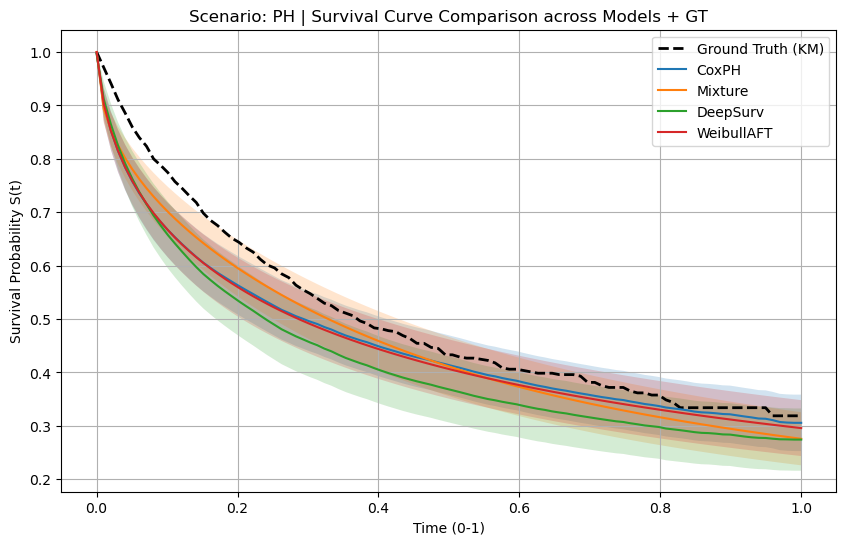

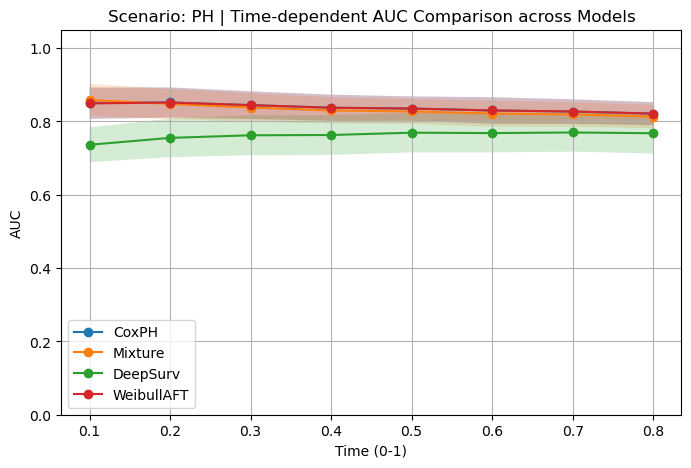

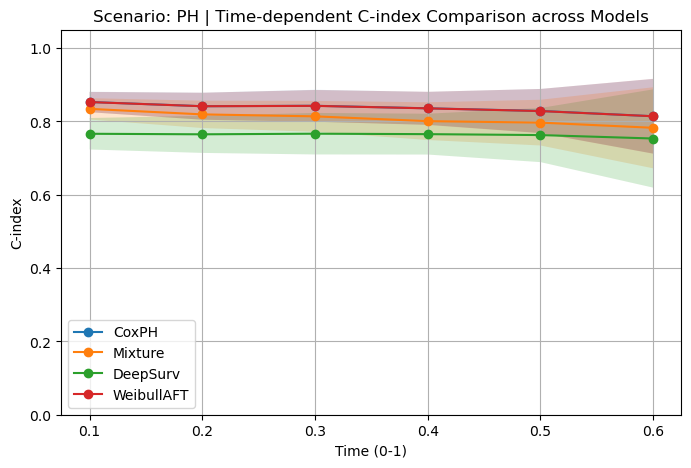


=== Scenario: nonlinear ===

--- Model: CoxPH ---

--- Model: Mixture ---

--- Model: DeepSurv ---

--- Model: WeibullAFT ---


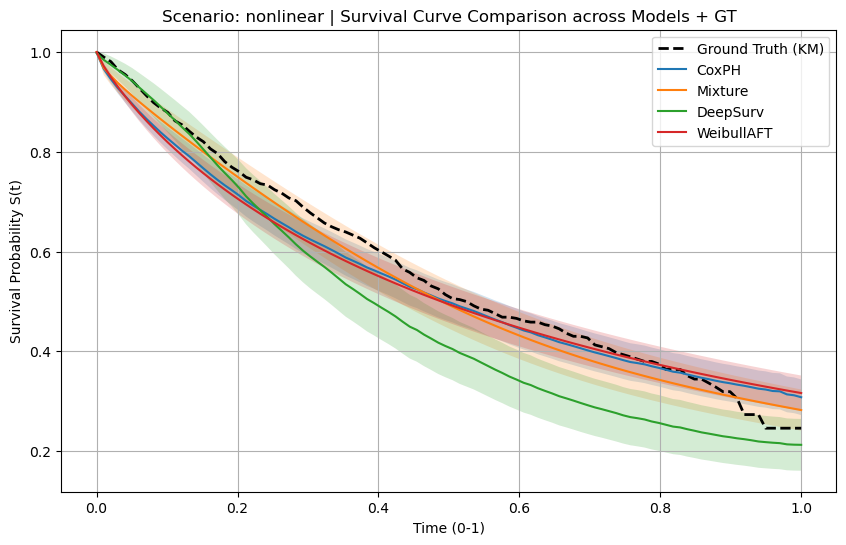

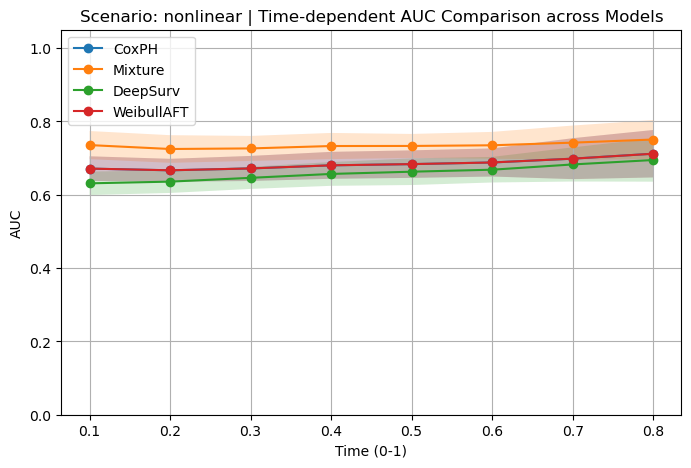

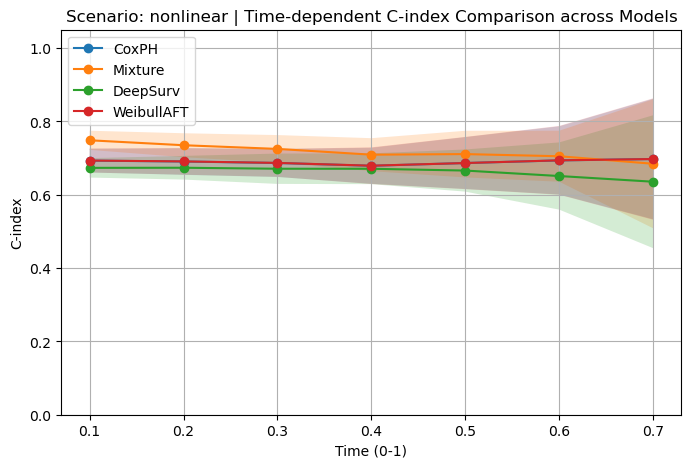


=== Scenario: mixture ===

--- Model: CoxPH ---

--- Model: Mixture ---

--- Model: DeepSurv ---

--- Model: WeibullAFT ---


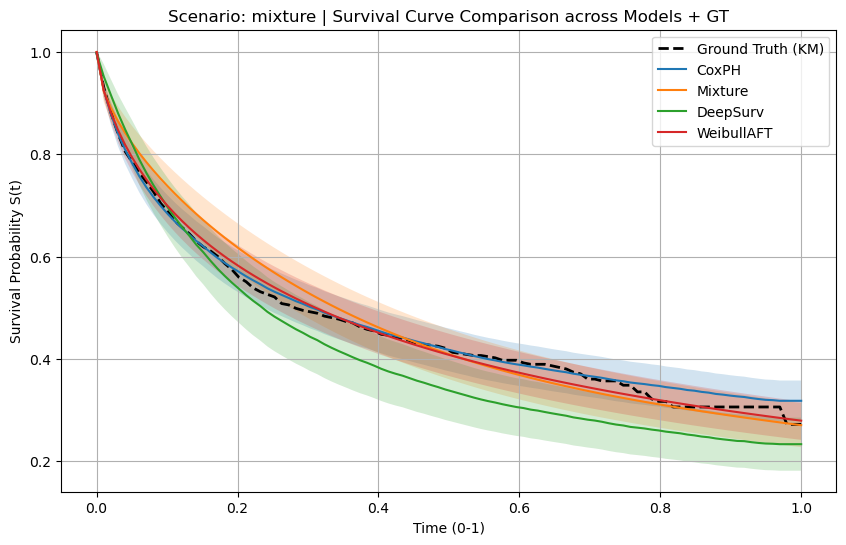

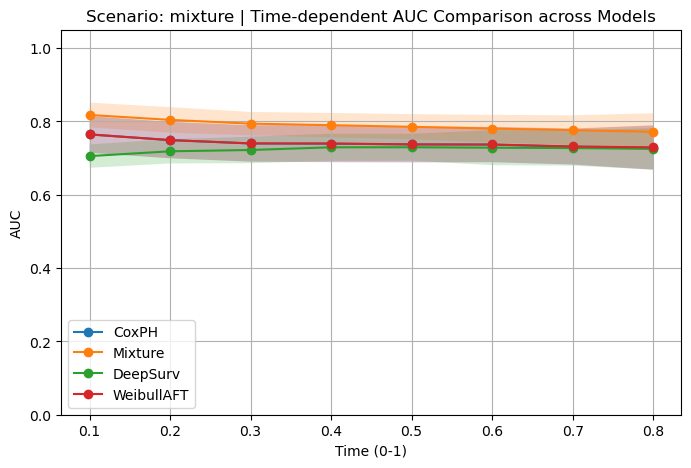

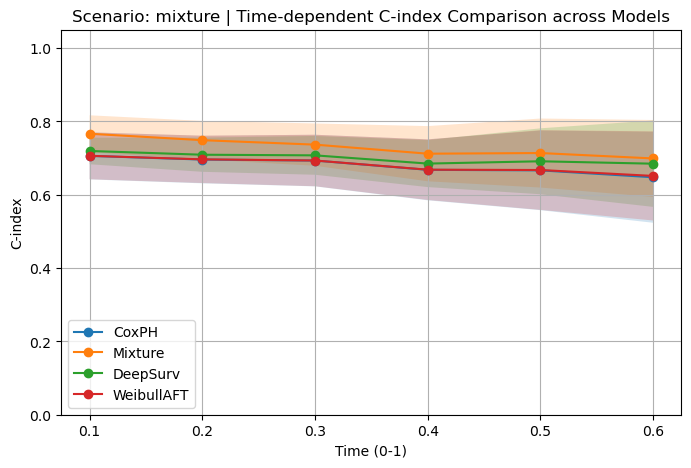


=== Final Results ===
     Scenario       Model  IBS_mean   IBS_std  AUC_global_mean  \
0          PH       CoxPH  0.220024  0.016663         0.837001   
1          PH     Mixture  0.215515  0.019984         0.831755   
2          PH    DeepSurv  0.260481  0.025844         0.761380   
3          PH  WeibullAFT  0.218174  0.016583         0.836870   
4   nonlinear       CoxPH  0.238351  0.014804         0.683902   
5   nonlinear     Mixture  0.242921  0.016744         0.734955   
6   nonlinear    DeepSurv  0.311444  0.020868         0.659722   
7   nonlinear  WeibullAFT  0.235006  0.014328         0.683917   
8     mixture       CoxPH  0.215827  0.012142         0.740689   
9     mixture     Mixture  0.209489  0.013815         0.789802   
10    mixture    DeepSurv  0.264463  0.017361         0.723138   
11    mixture  WeibullAFT  0.211182  0.011933         0.740978   

    AUC_global_std  AUC_t=0.1_mean  AUC_t=0.1_std  AUC_t=0.2_mean  \
0         0.032240        0.849893       0.042872

In [18]:
# === Import ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, WeibullAFTFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from tqdm import tqdm
import torchtuples as tt
from pycox.models import CoxPH as DeepSurvModel, DeepHitSingle
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# ---------------------
# Synthetic data generator
# ---------------------
def generate_synthetic_data(N, p, scenario='nonlinear', censoring_rate=0.3):
    X = np.random.randn(N, p)
    beta = np.random.randn(p)
    linpred = X @ beta
    U = np.random.uniform(size=N)

    if scenario == 'PH':
        # CoxPH / WeibullAFT perfect fit → PH 구조만 존재
        shape = np.random.uniform(1.2, 1.5)
        scale = np.random.uniform(0.8, 1.2)
        T = (-np.log(U) / (np.exp(linpred) / scale)) ** (1 / shape)

    elif scenario == 'nonlinear':
        # DeepSurv 우위 → nonlinear term만 사용 (linpred 제거 + scale tuning)
        nonlinear_pred = 1.5 * np.sin(X[:, 0]) + X[:, 1]**2 + np.cos(X[:, 2]) + 0.5 * X[:, 3]**3
        shape = np.random.uniform(1.2, 2.0)
        scale = np.random.uniform(0.8, 1.2)
        T = (-np.log(U) / (np.exp(nonlinear_pred) / scale)) ** (1 / shape)

    elif scenario == 'mixture':
        # Mixture Survival Model 우위 → component별 linpred 다르게 + strong separation
        logits = 4.0 * X[:, 0]
        pi_sample = 1 / (1 + np.exp(-logits))
        component = np.random.binomial(1, pi_sample)

        # component별 beta 더 orthogonal하게 구성
        beta1 = np.random.randn(p)
        beta2 = np.random.randn(p)
        beta2[0:3] += 5.0  # intentionally shift beta2 방향

        linpred1 = X @ beta1
        linpred2 = X @ beta2

        # Strong separation
        shape1 = np.random.uniform(1.2, 1.4)
        scale1 = np.random.uniform(1.0, 1.6)  # fast failure

        shape2 = np.random.uniform(3.5, 5.0)
        scale2 = np.random.uniform(0.3, 0.5)  # long survivor

        T1 = (-np.log(U) / (np.exp(linpred1) / scale1)) ** (1 / shape1)
        T2 = (-np.log(U) / (np.exp(linpred2) / scale2)) ** (1 / shape2)

        T = np.where(component == 0, T1, T2)

    else:
        raise ValueError("Unknown scenario")

    # Censoring
    C = np.random.uniform(0, np.percentile(T, (1 - censoring_rate) * 100), size=N)
    observed_time = np.minimum(T, C)
    event_observed = (T <= C).astype(int)

    # Output DataFrame
    df = pd.DataFrame({
        'time': observed_time,
        'event': event_observed
    })
    for j in range(p):
        df[f'x{j+1}'] = X[:, j]

    return df

# ---------------------
# Mixture model (PyTorch)
# ---------------------
class MixtureStretchedExponentialSurvival(nn.Module):
    def __init__(self, input_dim, num_components=2):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )
        self.pi_layer = nn.Linear(64, num_components)
        self.lam_layer = nn.Linear(64, num_components)
        self.alpha_layer = nn.Linear(64, num_components)

    def forward(self, x):
        h = self.backbone(x)
        pi = F.softmax(self.pi_layer(h), dim=1)
        lam = F.softplus(self.lam_layer(h)) + 1e-3
        a = F.softplus(self.alpha_layer(h)) + 1e-3
        return pi, lam, a

# ---------------------
# Survival function (Mixture)
# ---------------------
def survival_function(pi, lam, a, t_grid):
    t_grid = torch.tensor(t_grid).float().unsqueeze(0).unsqueeze(2)
    lam = lam.unsqueeze(1)
    a = a.unsqueeze(1)
    pi = pi.unsqueeze(1)
    S_components = torch.exp(-lam * t_grid ** a)
    S_total = torch.sum(pi * S_components, dim=2)
    return S_total

# ---------------------
# NLL loss (Mixture)
# ---------------------
def negative_log_likelihood(pi, lam, a, t, event):
    eps = 1e-8
    t = t.unsqueeze(1)
    log_surv = -lam * (t ** a)
    surv = torch.exp(log_surv)
    log_pdf = torch.log(lam * a + eps) + (a - 1) * torch.log(t + eps) - lam * (t ** a)
    mixture_pdf = torch.sum(pi * torch.exp(log_pdf), dim=1) + eps
    mixture_surv = torch.sum(pi * surv, dim=1) + eps
    log_likelihood = event * torch.log(mixture_pdf) + (1 - event) * torch.log(mixture_surv)
    return -log_likelihood.mean()

# ---------------------
# Common evaluation function
# ---------------------
from lifelines.utils import concordance_index
import numpy as np

def eval_model(surv_df, df, time_grid, eval_times,
               min_pos=5, min_neg=5, clip_eps=1e-6, enforce_monotonic=True):

    # --- 수치 안정화 & (선택) 단조성 보정 ---
    S = surv_df.clip(clip_eps, 1 - clip_eps)
    if enforce_monotonic:
        # 생존곡선은 시간에 따라 비증가해야 하므로 뒤에서부터 누적최소 적용
        S = S[::-1].cummin()[::-1]

    times  = df['time'].values
    events = df['event'].values.astype(int)

    # --- IBS (naive; 필요시 IPCW로 대체 가능) ---
    brier_scores = []
    for t in time_grid:
        S_t = S.loc[t].values
        Y_t = (times > t).astype(float)   # t를 넘겨 생존=1
        brier_scores.append(np.mean((S_t - Y_t) ** 2))
    ibs = np.trapz(brier_scores, time_grid) / (time_grid[-1] - time_grid[0])

    # --- Time-dependent AUC (at time t, score = S(t)) ---
    aucs = []
    for eval_t in eval_times:
        # time_grid에서 가장 가까운 시점 사용
        t = time_grid[np.argmin(np.abs(time_grid - eval_t))]
        y_true = (times > t).astype(int)   # 생존=1
        s_t    = S.loc[t].values           # 점수=생존확률(클수록 생존↑)
        n_pos, n_neg = (y_true == 1).sum(), (y_true == 0).sum()
        if n_pos >= min_pos and n_neg >= min_neg and np.std(s_t) > 0:
            aucs.append(roc_auc_score(y_true, s_t))
        else:
            aucs.append(np.nan)

    # --- Time-dependent C-index (at-risk 집단, score = S(t)) ---
    cindices = []
    for eval_t in eval_times:
        t = time_grid[np.argmin(np.abs(time_grid - eval_t))]
        at_risk = times >= t
        # at-risk 충분 + 사건 존재 확인
        if at_risk.sum() >= (min_pos + min_neg) and events[at_risk].sum() > 0:
            scores = S.loc[t].values[at_risk]   # lifelines는 "클수록 생존↑" 점수에 적합
            ci = concordance_index(times[at_risk], scores, events[at_risk])
        else:
            ci = np.nan
        cindices.append(ci)

    return ibs, aucs, cindices


# === 설정 ===
k_runs = 50
scenarios = ['PH', 'nonlinear', 'mixture']
N = 1000
p = 10
num_epochs = 1000
lr = 1e-4
time_grid = np.linspace(0, 1, 100)
eval_times = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])

# 결과 저장용 DF
results_df = pd.DataFrame(columns=['Scenario', 'Model', 
                                   'IBS_mean', 'IBS_std', 
                                   'AUC_global_mean', 'AUC_global_std'] + 
                          sum([[f'AUC_t={t}_mean', f'AUC_t={t}_std'] for t in eval_times], []) + 
                          sum([[f'Cindex_t>={t}_mean', f'Cindex_t={t}_std'] for t in eval_times], []))

raw_results_df = pd.DataFrame(columns=['Scenario', 'Model', 'Run', 'IBS'] + 
                              [f'AUC_t={t}' for t in eval_times] + 
                              [f'Cindex_t>={t}' for t in eval_times])

# === Main Loop ===
for scenario in scenarios:
    print(f"\n=== Scenario: {scenario} ===")

    S_curve_model_dict = {}
    auc_model_dict = {}
    cindex_model_dict = {}

    df_gt = generate_synthetic_data(N, p, scenario=scenario)
    df_gt['time'] = df_gt['time'] / df_gt['time'].max()
    kmf = KaplanMeierFitter()
    kmf.fit(df_gt['time'], event_observed=df_gt['event'])
    km_surv = kmf.survival_function_at_times(time_grid).values

    for model_name in ['CoxPH', 'Mixture', 'DeepSurv', 'WeibullAFT']:
        print(f"\n--- Model: {model_name} ---")

        ibs_list = []
        auc_list = []
        cindex_list = []

        S_curve_list = []

        for run in range(k_runs):
            np.random.seed(run)
            torch.manual_seed(run)

            df = generate_synthetic_data(N, p, scenario=scenario)
            df['time'] = df['time'] / df['time'].max()
            x_cols = [f'x{j+1}' for j in range(p)]

            df_train, df_valid = train_test_split(df, test_size=0.3, random_state=run)
            X_train = df_train[x_cols].values.astype(np.float32)
            T_train = df_train['time'].values.astype(np.float32)
            E_train = df_train['event'].values.astype(np.float32)
            X_valid = df_valid[x_cols].values.astype(np.float32)
            valid_df = df_valid.copy()

            if model_name == 'CoxPH':
                cph = CoxPHFitter()
                cph.fit(df_train, duration_col='time', event_col='event')
                surv_funcs = cph.predict_survival_function(df_valid, times=time_grid)
                ibs, aucs, cindices = eval_model(surv_funcs, valid_df, time_grid, eval_times)
                S_curve_list.append(surv_funcs)
                # === RAW RESULTS 저장 === 🔵 (CoxPH 블록 안에도 추가 필요)
                raw_results_df.loc[len(raw_results_df)] = [scenario, model_name, run, ibs] + aucs + cindices

            else:
                if model_name == 'Mixture':
                    device = 'cuda' if torch.cuda.is_available() else 'cpu'
                    model = MixtureStretchedExponentialSurvival(input_dim=p).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    X_train_tensor = torch.tensor(X_train).to(device)
                    T_train_tensor = torch.tensor(T_train).to(device)
                    E_train_tensor = torch.tensor(E_train).to(device)

                    model.train()
                    for epoch in range(num_epochs):
                        optimizer.zero_grad()
                        pi, lam, a = model(X_train_tensor)
                        loss = negative_log_likelihood(pi, lam, a, T_train_tensor, E_train_tensor)
                        loss.backward()
                        optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        X_valid_tensor = torch.tensor(X_valid).to(device)
                        pi, lam, a = model(X_valid_tensor)
                        S_pred = survival_function(pi, lam, a, time_grid).cpu().numpy()
                    S_df = pd.DataFrame(S_pred.T, index=time_grid)

                elif model_name == 'DeepSurv':
                    df_train_ = df_train.copy()
                    df_train_['event'] = df_train_['event'].astype(bool)
                    X_train_ = df_train_[x_cols].values.astype(np.float32)
                    y_train_ = (df_train_['time'].values, df_train_['event'].values)

                    net_ds = tt.practical.MLPVanilla(p, [64, 64], activation=torch.nn.ReLU, out_features=1)
                    model_ds = DeepSurvModel(net_ds, tt.optim.Adam)
                    model_ds.fit(X_train_, y_train_, batch_size=128, epochs=num_epochs, verbose=False)
                    model_ds.compute_baseline_hazards()
                    cumhaz = model_ds.predict_cumulative_hazards(X_valid)
                    cumhaz_interp = cumhaz.reindex(time_grid, method='nearest')
                    S_df = np.exp(-cumhaz_interp)
                    
                
                
                elif model_name == 'WeibullAFT':
                    aft = WeibullAFTFitter(penalizer=0.01)
                    aft.fit(df_train, duration_col='time', event_col='event')
                    surv_wb = []
                    for t in time_grid:
                        surv_t = aft.predict_survival_function(df_valid, times=[t]).values.flatten()
                        surv_wb.append(surv_t)
                    S_df = pd.DataFrame(np.array(surv_wb), index=time_grid)

                ibs, aucs, cindices = eval_model(S_df, valid_df, time_grid, eval_times)
                S_curve_list.append(S_df)
                raw_results_df.loc[len(raw_results_df)] = [scenario, model_name, run, ibs] + aucs + cindices

            ibs_list.append(ibs)
            auc_list.append(aucs)
            cindex_list.append(cindices)

        global_auc = np.nanmean([np.nanmean(a) for a in auc_list])
        global_auc_std = np.nanstd([np.nanmean(a) for a in auc_list])

        results_df.loc[len(results_df)] = [scenario, model_name,
                                   np.mean(ibs_list), np.std(ibs_list),
                                   global_auc, global_auc_std] + \
                                  sum([[np.mean(a), np.std(a)] for a in zip(*auc_list)], []) + \
                                  sum([[np.mean(c), np.std(c)] for c in zip(*cindex_list)], [])


        S_curve_array = np.stack([df.values for df in S_curve_list], axis=0)
        S_mean = S_curve_array.mean(axis=0).mean(axis=1)
        S_std = S_curve_array.mean(axis=0).std(axis=1)
        S_curve_model_dict[model_name] = (S_mean, S_std)

        auc_array = np.array(auc_list)
        auc_mean = auc_array.mean(axis=0)
        auc_std = auc_array.std(axis=0)
        auc_model_dict[model_name] = (auc_mean, auc_std)

        cindex_array = np.array(cindex_list)
        cindex_mean = cindex_array.mean(axis=0)
        cindex_std = cindex_array.std(axis=0)
        cindex_model_dict[model_name] = (cindex_mean, cindex_std)

    # === 모델 간 비교 시각화 ===
    plt.figure(figsize=(10,6))
    plt.plot(time_grid, km_surv, label='Ground Truth (KM)', color='black', linestyle='--', linewidth=2)
    for model_name in S_curve_model_dict.keys():
        S_mean, S_std = S_curve_model_dict[model_name]
        plt.plot(time_grid, S_mean, label=model_name)
        plt.fill_between(time_grid, S_mean - S_std, S_mean + S_std, alpha=0.2)
    plt.title(f"Scenario: {scenario} | Survival Curve Comparison across Models + GT")
    plt.xlabel("Time (0-1)")
    plt.ylabel("Survival Probability S(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    for model_name in auc_model_dict.keys():
        auc_mean, auc_std = auc_model_dict[model_name]
        plt.plot(eval_times, auc_mean, marker='o', label=model_name)
        plt.fill_between(eval_times, auc_mean - auc_std, auc_mean + auc_std, alpha=0.2)
    plt.title(f"Scenario: {scenario} | Time-dependent AUC Comparison across Models")
    plt.xlabel("Time (0-1)")
    plt.ylabel("AUC")
    plt.ylim(0.0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    for model_name in cindex_model_dict.keys():
        cindex_mean, cindex_std = cindex_model_dict[model_name]
        plt.plot(eval_times, cindex_mean, marker='o', label=model_name)
        plt.fill_between(eval_times, cindex_mean - cindex_std, cindex_mean + cindex_std, alpha=0.2)
    plt.title(f"Scenario: {scenario} | Time-dependent C-index Comparison across Models")
    plt.xlabel("Time (0-1)")
    plt.ylabel("C-index")
    plt.ylim(0.0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

# 최종 결과 출력
print("\n=== Final Results ===")
print(results_df)
import os
os.makedirs("raw_data", exist_ok=True)
results_df.to_csv(f"survival_model_comparison_{k_runs}runs_mean1.csv", index=False)
raw_results_df.to_csv(f"raw_data/survival_model_comparison_{k_runs}runs_RAW1.csv", index=False)
print(f"\n=== Raw results saved to raw_data/survival_model_comparison_{k_runs}runs_RAW1.csv ===")